In [ ]:
from glob import glob 

result_root_dir = "/workspace/data/results/gender_parent_comp"

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from scipy.stats import mode

def pkl_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# 모든 모델 결과 로드
pkl_files = glob(f"{result_root_dir}/*.pkl")
results_dict = {}

for pkl_file in pkl_files:
    model_name = pkl_file.split('/')[-1].split('.')[0]
    pkl_dict = pkl_load(pkl_file)
    results_dict[model_name] = pkl_dict
    print(f"✓ {model_name} 로드 완료")



## 성능 전체비교

In [ ]:
# 성능 전체비교 테이블 생성
from scipy.stats import t
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef
)

def calculate_ci(values, confidence=0.95):
    """95% 신뢰구간 계산"""
    n = len(values)
    if n < 2:
        return np.nan, np.nan
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    se = std / np.sqrt(n)
    t_value = t.ppf((1 + confidence) / 2, df=n-1)
    ci_lower = mean - t_value * se
    ci_upper = mean + t_value * se
    return ci_lower, ci_upper

def calculate_specificity(y_true, y_pred):
    """Specificity (True Negative Rate) 계산"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def calculate_balanced_accuracy(y_true, y_pred):
    """Balanced Accuracy 계산"""
    recall = recall_score(y_true, y_pred)
    specificity = calculate_specificity(y_true, y_pred)
    return (recall + specificity) / 2

def format_exp_name(exp_name):
    """실험 이름을 읽기 쉽게 포맷팅"""
    if not exp_name or not isinstance(exp_name, str):
        return exp_name
    
    parts = exp_name.replace('4_EXP_Methods_', '').split('_')
    if len(parts) >= 2:
        feature_set = parts[0]
        gender = parts[1]
        
        feature_map = {'A': '부모+청소년', 'P': '부모', 'Ad': '청소년'}
        gender_map = {'A': '전체', 'M': '남', 'FM': '여'}
        
        feature_label = feature_map.get(feature_set, feature_set)
        gender_label = gender_map.get(gender, gender)
        
        return f"{feature_label} ({gender_label})"
    return exp_name

# 모든 실험-모델 조합의 메트릭 수집
all_metrics = []

for exp_name, result in results_dict.items():
    # 실험 메타데이터 추출
    exp_name_clean = result.get('exp_name', exp_name)
    feature_set = result.get('feature_set', '')
    gender = result.get('gender', '')
    
    test_labels = result.get('test_labels')
    test_preds = result.get('test_preds', {})
    test_proba = result.get('test_proba', {})
    
    if test_labels is None:
        continue
    if not isinstance(test_preds, dict) or not isinstance(test_proba, dict):
        continue
    
    # 각 모델별로 처리
    for model_name in test_preds.keys():
        if model_name not in test_proba:
            continue
        
        preds_list = test_preds[model_name]
        proba_list = test_proba[model_name]
        
        if not isinstance(preds_list, list) or len(preds_list) == 0:
            continue
        if not isinstance(proba_list, list) or len(proba_list) == 0:
            continue
        
        # 각 fold별 메트릭 계산
        accs, precs, recalls, f1s, aucs, specs, bal_accs, mccs = [], [], [], [], [], [], [], []
        
        for fold_pred, fold_proba in zip(preds_list, proba_list):
            accs.append(accuracy_score(test_labels, fold_pred))
            precs.append(precision_score(test_labels, fold_pred, zero_division=0))
            recalls.append(recall_score(test_labels, fold_pred, zero_division=0))
            f1s.append(f1_score(test_labels, fold_pred, zero_division=0))
            aucs.append(roc_auc_score(test_labels, fold_proba))
            specs.append(calculate_specificity(test_labels, fold_pred))
            bal_accs.append(calculate_balanced_accuracy(test_labels, fold_pred))
            mccs.append(matthews_corrcoef(test_labels, fold_pred))
        
        # 평균 및 통계 계산
        def format_ci_mean_std(values, metric_name):
            mean_val = np.mean(values)
            std_val = np.std(values, ddof=1)
            ci_lower, ci_upper = calculate_ci(values)
            return {
                f"{metric_name}_mean": mean_val,
                f"{metric_name}_std": std_val,
                f"{metric_name}_ci_lower": ci_lower,
                f"{metric_name}_ci_upper": ci_upper,
            }
        
        metric_dict = {
            "Experiment": format_exp_name(exp_name_clean),
            "Exp_Name": exp_name_clean,
            "Feature_Set": feature_set,
            "Gender": gender,
            "Model": model_name,
            **format_ci_mean_std(accs, "Accuracy"),
            **format_ci_mean_std(precs, "Precision"),
            **format_ci_mean_std(recalls, "Recall"),
            **format_ci_mean_std(f1s, "F1"),
            **format_ci_mean_std(aucs, "ROC_AUC"),
            **format_ci_mean_std(specs, "Specificity"),
            **format_ci_mean_std(bal_accs, "Balanced_Accuracy"),
            **format_ci_mean_std(mccs, "MCC"),
        }
        
        all_metrics.append(metric_dict)

# DataFrame 생성
df_all_metrics = pd.DataFrame(all_metrics)

if len(df_all_metrics) > 0:
    # 실험 방법 순서 정의
    exp_order = [
        '4_EXP_Methods_A_A', '4_EXP_Methods_A_M', '4_EXP_Methods_A_FM',
        '4_EXP_Methods_P_A', '4_EXP_Methods_P_M', '4_EXP_Methods_P_FM',
        '4_EXP_Methods_Ad_A', '4_EXP_Methods_Ad_M', '4_EXP_Methods_Ad_FM'
    ]
    
    # 실험 순서에 맞게 정렬
    exp_order_dict = {exp: i for i, exp in enumerate(exp_order)}
    df_all_metrics['exp_order'] = df_all_metrics['Exp_Name'].map(lambda x: exp_order_dict.get(x, 999))
    df_all_metrics = df_all_metrics.sort_values(['exp_order', 'ROC_AUC_mean'], ascending=[True, False])
    df_all_metrics = df_all_metrics.drop('exp_order', axis=1)
    
    print("="*100)
    print("📊 전체 성능 비교 테이블 (모든 실험 방법 × 모든 모델)")
    print("="*100)
    
    # 주요 메트릭만 선택하여 표시
    display_cols = ['Experiment', 'Model', 'ROC_AUC_mean', 'ROC_AUC_std', 
                    'F1_mean', 'F1_std', 'Balanced_Accuracy_mean', 'Balanced_Accuracy_std',
                    'Precision_mean', 'Recall_mean', 'Accuracy_mean', 'MCC_mean']
    
    # 요약 테이블 생성 (CI 포함)
    summary_table = df_all_metrics[display_cols].copy()
    
    # CI 형식으로 표시할 컬럼 추가
    for metric in ['ROC_AUC', 'F1', 'Balanced_Accuracy']:
        summary_table[f"{metric}_CI"] = df_all_metrics.apply(
            lambda row: f"[{row[f'{metric}_ci_lower']:.3f}, {row[f'{metric}_ci_upper']:.3f}]",
            axis=1
        )
    
    # 컬럼명 정리
    summary_table_display = summary_table.copy()
    summary_table_display = summary_table_display.rename(columns={
        'ROC_AUC_mean': 'ROC AUC',
        'ROC_AUC_std': 'ROC AUC (std)',
        'ROC_AUC_CI': 'ROC AUC (95% CI)',
        'F1_mean': 'F1 Score',
        'F1_std': 'F1 (std)',
        'F1_CI': 'F1 (95% CI)',
        'Balanced_Accuracy_mean': 'Balanced Acc',
        'Balanced_Accuracy_std': 'Bal Acc (std)',
        'Balanced_Accuracy_CI': 'Bal Acc (95% CI)',
        'Precision_mean': 'Precision',
        'Recall_mean': 'Recall',
        'Accuracy_mean': 'Accuracy',
        'MCC_mean': 'MCC'
    })
    
    # 소수점 자리수 조정
    for col in summary_table_display.columns:
        if col not in ['Experiment', 'Model'] and '_CI' not in col:
            if summary_table_display[col].dtype in [np.float64, np.float32]:
                summary_table_display[col] = summary_table_display[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    display(summary_table_display)
    
    # 실험 방법별 최고 성능 모델 표시
    print("\n" + "="*100)
    print("🏆 실험 방법별 최고 성능 모델 (ROC AUC 기준)")
    print("="*100)
    
    best_models = []
    for exp_name in exp_order:
        exp_data = df_all_metrics[df_all_metrics['Exp_Name'] == exp_name]
        if len(exp_data) > 0:
            best_idx = exp_data['ROC_AUC_mean'].idxmax()
            best_row = exp_data.loc[best_idx]
            best_models.append({
                'Experiment': best_row['Experiment'],
                'Model': best_row['Model'],
                'ROC_AUC': best_row['ROC_AUC_mean'],
                'ROC_AUC_CI': f"[{best_row['ROC_AUC_ci_lower']:.3f}, {best_row['ROC_AUC_ci_upper']:.3f}]",
                'F1': best_row['F1_mean'],
                'Balanced_Accuracy': best_row['Balanced_Accuracy_mean']
            })
    
    if len(best_models) > 0:
        best_df = pd.DataFrame(best_models)
        display(best_df)
    
    # 실험 방법별 평균 성능 (모든 모델 평균)
    print("\n" + "="*100)
    print("📊 실험 방법별 평균 성능 (모든 모델 평균)")
    print("="*100)
    
    exp_avg = df_all_metrics.groupby('Experiment').agg({
        'ROC_AUC_mean': 'mean',
        'F1_mean': 'mean',
        'Balanced_Accuracy_mean': 'mean',
        'Precision_mean': 'mean',
        'Recall_mean': 'mean',
        'Accuracy_mean': 'mean',
        'MCC_mean': 'mean'
    }).round(4)
    exp_avg = exp_avg.sort_values('ROC_AUC_mean', ascending=False)
    exp_avg.columns = ['ROC AUC', 'F1 Score', 'Balanced Acc', 'Precision', 'Recall', 'Accuracy', 'MCC']
    display(exp_avg)
    
    print(f"\n✅ 총 {len(df_all_metrics)}개 조합 (실험 방법 {len(df_all_metrics['Exp_Name'].unique())}개 × 모델 {len(df_all_metrics['Model'].unique())}개) 분석 완료")
else:
    print("⚠️  비교할 데이터가 없습니다.")

# 1. ROC / PR Curve 

📊 ROC/PR Curves - Gender and Feature Comparison (2x2 Layout)


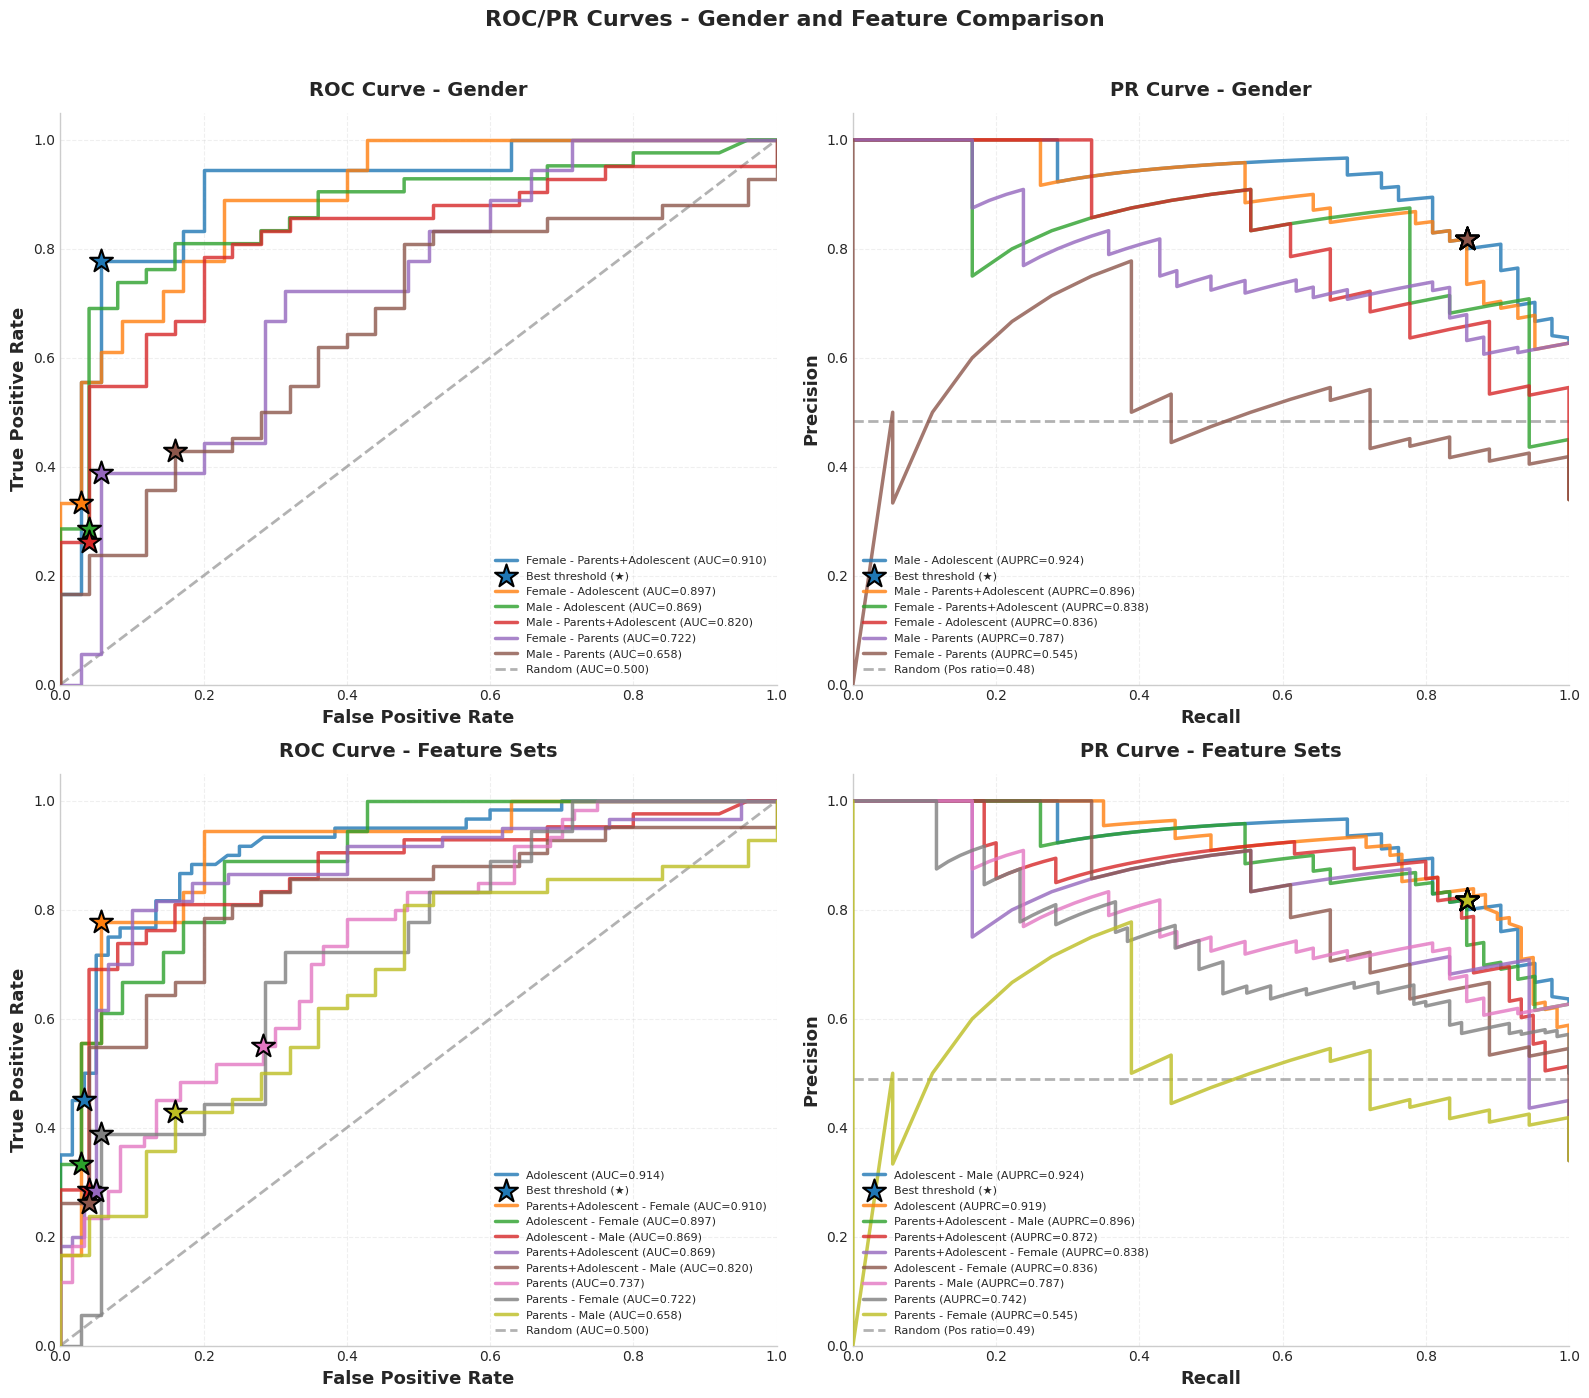


✅ ROC/PR curves generation completed (Publication quality, Best Threshold displayed)


In [39]:
# Gender (AUROC / PR) + Feature(A/P/Ad) Comparison - Publication Quality (Best Threshold Display)
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

# Font settings for publication
try:
    import matplotlib.font_manager as fm
    # Find available fonts
    font_list = [f.name for f in fm.fontManager.ttflist]
    korean_fonts = ['NanumGothic', 'NanumBarunGothic', 'Malgun Gothic', 'AppleGothic', 'Noto Sans CJK KR']
    for font in korean_fonts:
        if font in font_list:
            matplotlib.rcParams['font.family'] = font
            break
except:
    pass

# Best threshold calculation functions
def find_best_threshold_roc(y_true, y_proba):
    """Find threshold that maximizes Youden's J statistic in ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    best_threshold = thresholds[best_idx]
    best_fpr = fpr[best_idx]
    best_tpr = tpr[best_idx]
    return best_threshold, best_fpr, best_tpr

def find_best_threshold_pr(y_true, y_proba):
    """Find threshold that maximizes F1 score in PR curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # Calculate F1 score (thresholds has one less element than precision/recall)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    return best_threshold, best_precision, best_recall

# Collect ROC/PR curves by gender
gender_curves = {
    'Male': {'roc': [], 'pr': []},
    'Female': {'roc': [], 'pr': []}
}

# Collect ROC/PR curves by feature set
feature_curves = {
    'Parents+Adolescent': {'roc': [], 'pr': []},
    'Parents': {'roc': [], 'pr': []},
    'Adolescent': {'roc': [], 'pr': []}
}

for exp_name, result in results_dict.items():
    exp_name_clean = result.get('exp_name', exp_name)
    feature_set = result.get('feature_set', '')
    gender = result.get('gender', '')
    test_labels = result.get('test_labels')
    test_proba = result.get('test_proba', {})
    fold_thresholds = result.get('fold_thresholds', {})
    
    if test_labels is None:
        continue
    if not isinstance(test_proba, dict):
        continue
    
    # Determine feature group
    feature_group = None
    if feature_set == 'A':
        feature_group = 'Parents+Adolescent'
    elif feature_set == 'P':
        feature_group = 'Parents'
    elif feature_set == 'Ad':
        feature_group = 'Adolescent'
    
    # Determine gender group
    gender_group = None
    if gender == 'M':
        gender_group = 'Male'
    elif gender == 'FM':
        gender_group = 'Female'
    
    # Process each model
    for model_name in test_proba.keys():
        proba_list = test_proba[model_name]
        
        if not isinstance(proba_list, list) or len(proba_list) == 0:
            continue
        
        # Average probability across folds (Soft Voting)
        proba_array = np.array(proba_list)  # (n_folds, n_samples)
        avg_proba = np.mean(proba_array, axis=0)
        
        # ROC curve (using test data for plotting)
        fpr, tpr, thresholds_roc = roc_curve(test_labels, avg_proba)
        auc_roc = roc_auc_score(test_labels, avg_proba)
        
        # Best threshold from validation data (average across folds)
        if model_name in fold_thresholds and len(fold_thresholds[model_name]) > 0:
            # Use validation thresholds (average across folds)
            val_best_threshold = np.mean(fold_thresholds[model_name])
        else:
            # Fallback: calculate from test data if validation thresholds not available
            val_best_threshold, _, _ = find_best_threshold_roc(test_labels, avg_proba)
        
        # Find the point on ROC curve corresponding to validation threshold
        # thresholds_roc has one more element than fpr/tpr (includes inf at the end)
        # Find closest threshold in ROC curve (excluding the last inf value)
        threshold_idx = np.argmin(np.abs(thresholds_roc[:-1] - val_best_threshold))
        best_fpr = fpr[threshold_idx]
        best_tpr = tpr[threshold_idx]
        best_thresh_roc = val_best_threshold
        
        # PR curve (using test data for plotting)
        precision, recall, thresholds_pr = precision_recall_curve(test_labels, avg_proba)
        auprc = average_precision_score(test_labels, avg_proba)
        
        # Find the point on PR curve corresponding to validation threshold
        # thresholds_pr has one less element than precision/recall
        # Find closest threshold in PR curve
        threshold_idx_pr = np.argmin(np.abs(thresholds_pr - val_best_threshold))
        # Use the corresponding precision and recall
        best_precision = precision[threshold_idx_pr]
        best_recall = recall[threshold_idx_pr]
        best_thresh_pr = val_best_threshold
        
        # Legend for gender-based graphs: Gender - Feature (AUC)
        if gender_group and feature_group:
            label_roc_gender = f"{gender_group} - {feature_group} (AUC={auc_roc:.3f})"
            label_pr_gender = f"{gender_group} - {feature_group} (AUPRC={auprc:.3f})"
        elif gender_group:
            label_roc_gender = f"{gender_group} (AUC={auc_roc:.3f})"
            label_pr_gender = f"{gender_group} (AUPRC={auprc:.3f})"
        elif feature_group:
            label_roc_gender = f"{feature_group} (AUC={auc_roc:.3f})"
            label_pr_gender = f"{feature_group} (AUPRC={auprc:.3f})"
        else:
            label_roc_gender = f"AUC={auc_roc:.3f}"
            label_pr_gender = f"AUPRC={auprc:.3f}"
        
        # Legend for feature-based graphs: Feature - Gender (AUC)
        if feature_group and gender_group:
            label_roc_feature = f"{feature_group} - {gender_group} (AUC={auc_roc:.3f})"
            label_pr_feature = f"{feature_group} - {gender_group} (AUPRC={auprc:.3f})"
        elif feature_group:
            label_roc_feature = f"{feature_group} (AUC={auc_roc:.3f})"
            label_pr_feature = f"{feature_group} (AUPRC={auprc:.3f})"
        elif gender_group:
            label_roc_feature = f"{gender_group} (AUC={auc_roc:.3f})"
            label_pr_feature = f"{gender_group} (AUPRC={auprc:.3f})"
        else:
            label_roc_feature = f"AUC={auc_roc:.3f}"
            label_pr_feature = f"AUPRC={auprc:.3f}"
        
        # Add to gender-based curves
        if gender_group:
            gender_curves[gender_group]['roc'].append((fpr, tpr, auc_roc, label_roc_gender, best_thresh_roc, best_fpr, best_tpr))
            gender_curves[gender_group]['pr'].append((recall, precision, auprc, label_pr_gender, best_thresh_pr, best_prec, best_rec))
        
        # Add to feature-based curves
        if feature_group:
            feature_curves[feature_group]['roc'].append((fpr, tpr, auc_roc, label_roc_feature, best_thresh_roc, best_fpr, best_tpr))
            feature_curves[feature_group]['pr'].append((recall, precision, auprc, label_pr_feature, best_thresh_pr, best_prec, best_rec))

# Publication-quality style settings
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")

# ========== ROC/PR Curves (2x2 Layout) ==========
# Color map generation (publication-quality - cleaner colors)
colors = plt.cm.tab10(np.linspace(0, 1, 10))

print("="*100)
print("📊 ROC/PR Curves - Gender and Feature Comparison (2x2 Layout)")
print("="*100)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.patch.set_facecolor('white')

# ========== First Row: Gender-based ==========
# Top left: Gender-based ROC (Male and Female included)
ax = axes[0, 0]
best_thresh_shown = False
# Display all gender group ROC curves in one graph
all_gender_roc = []
all_gender_roc.extend(gender_curves['Male']['roc'])
all_gender_roc.extend(gender_curves['Female']['roc'])

if len(all_gender_roc) > 0:
    # Sort by AUC (descending)
    all_gender_roc_sorted = sorted(all_gender_roc, key=lambda x: x[2], reverse=True)
    for idx, (fpr, tpr, auc_val, label, best_thresh, best_fpr_val, best_tpr_val) in enumerate(all_gender_roc_sorted):
        ax.plot(fpr, tpr, lw=2.5, label=label, color=colors[idx % len(colors)], alpha=0.8, zorder=3)
        # Display best threshold (star) - show in legend only once
        if not best_thresh_shown:
            ax.scatter(best_fpr_val, best_tpr_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5, label='Best threshold (★)')
            best_thresh_shown = True
        else:
            ax.scatter(best_fpr_val, best_tpr_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5)
ax.plot([0, 1], [0, 1], '--', color='gray', lw=2, label='Random (AUC=0.500)', alpha=0.6, zorder=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve - Gender', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower right', fontsize=8, framealpha=0.95, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Top right: Gender-based PR (Male and Female included)
ax = axes[0, 1]
best_thresh_shown_pr = False
# Display all gender group PR curves in one graph
all_gender_pr = []
all_gender_pr.extend(gender_curves['Male']['pr'])
all_gender_pr.extend(gender_curves['Female']['pr'])

# Calculate random baseline (average positive ratio of gender-based data)
pos_ratios_gender = []
for exp_name, result in results_dict.items():
    gender = result.get('gender', '')
    if gender in ['M', 'FM']:
        test_labels = result.get('test_labels')
        if test_labels is not None:
            pos_ratios_gender.append(np.mean(test_labels))
pos_ratio_gender_avg = np.mean(pos_ratios_gender) if len(pos_ratios_gender) > 0 else 0.5

if len(all_gender_pr) > 0:
    # Sort by AUPRC (descending)
    all_gender_pr_sorted = sorted(all_gender_pr, key=lambda x: x[2], reverse=True)
    for idx, (recall, precision, auprc, label, best_thresh, best_prec_val, best_rec_val) in enumerate(all_gender_pr_sorted):
        ax.plot(recall, precision, lw=2.5, label=label, color=colors[idx % len(colors)], alpha=0.8, zorder=3)
        # Display best threshold (star) - show in legend only once
        if not best_thresh_shown_pr:
            ax.scatter(best_rec_val, best_prec_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5, label='Best threshold (★)')
            best_thresh_shown_pr = True
        else:
            ax.scatter(best_rec_val, best_prec_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5)
ax.hlines(pos_ratio_gender_avg, 0, 1, colors='gray', linestyles='--', 
         label=f'Random (Pos ratio={pos_ratio_gender_avg:.2f})', lw=2, alpha=0.6, zorder=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('PR Curve - Gender', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower left', fontsize=8, framealpha=0.95, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ========== Second Row: Feature-based ==========
# Bottom left: Feature-based ROC (Parents+Adolescent, Parents, Adolescent all included)
ax = axes[1, 0]
best_thresh_shown = False
# Display all feature group ROC curves in one graph
all_feature_roc = []
for feature_group in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    all_feature_roc.extend(feature_curves[feature_group]['roc'])

if len(all_feature_roc) > 0:
    # Sort by AUC (descending)
    all_feature_roc_sorted = sorted(all_feature_roc, key=lambda x: x[2], reverse=True)
    for idx, (fpr, tpr, auc_val, label, best_thresh, best_fpr_val, best_tpr_val) in enumerate(all_feature_roc_sorted):
        ax.plot(fpr, tpr, lw=2.5, label=label, color=colors[idx % len(colors)], alpha=0.8, zorder=3)
        # Display best threshold (star) - show in legend only once
        if not best_thresh_shown:
            ax.scatter(best_fpr_val, best_tpr_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5, label='Best threshold (★)')
            best_thresh_shown = True
        else:
            ax.scatter(best_fpr_val, best_tpr_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5)
ax.plot([0, 1], [0, 1], '--', color='gray', lw=2, label='Random (AUC=0.500)', alpha=0.6, zorder=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve - Feature Sets', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower right', fontsize=8, framealpha=0.95, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Bottom right: Feature-based PR (Parents+Adolescent, Parents, Adolescent all included)
ax = axes[1, 1]
best_thresh_shown_pr = False
# Display all feature group PR curves in one graph
all_feature_pr = []
for feature_group in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    all_feature_pr.extend(feature_curves[feature_group]['pr'])

# Calculate random baseline (positive ratio of all data)
pos_ratios = []
for exp_name, result in results_dict.items():
    test_labels = result.get('test_labels')
    if test_labels is not None:
        pos_ratios.append(np.mean(test_labels))
pos_ratio_avg = np.mean(pos_ratios) if len(pos_ratios) > 0 else 0.5

if len(all_feature_pr) > 0:
    # Sort by AUPRC (descending)
    all_feature_pr_sorted = sorted(all_feature_pr, key=lambda x: x[2], reverse=True)
    for idx, (recall, precision, auprc, label, best_thresh, best_prec_val, best_rec_val) in enumerate(all_feature_pr_sorted):
        ax.plot(recall, precision, lw=2.5, label=label, color=colors[idx % len(colors)], alpha=0.8, zorder=3)
        # Display best threshold (star) - show in legend only once
        if not best_thresh_shown_pr:
            ax.scatter(best_rec_val, best_prec_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5, label='Best threshold (★)')
            best_thresh_shown_pr = True
        else:
            ax.scatter(best_rec_val, best_prec_val, marker='*', s=300, color=colors[idx % len(colors)], 
                      edgecolors='black', linewidths=1.5, zorder=5)
ax.hlines(pos_ratio_avg, 0, 1, colors='gray', linestyles='--', 
         label=f'Random (Pos ratio={pos_ratio_avg:.2f})', lw=2, alpha=0.6, zorder=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('PR Curve - Feature Sets', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower left', fontsize=8, framealpha=0.95, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle('ROC/PR Curves - Gender and Feature Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

print("\n✅ ROC/PR curves generation completed (Publication quality, Best Threshold displayed)")

## 2. Box Plot

📊 Box Plots - Gender and Feature Comparison (ROC AUC, F1, Balanced Accuracy, MCC)


/tmp/ipykernel_344705/662193788.py:154: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(all_data_roc, labels=all_labels_roc, patch_artist=True,
/tmp/ipykernel_344705/662193788.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(all_data_f1, labels=all_labels_f1, patch_artist=True,
/tmp/ipykernel_344705/662193788.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(all_data_bal, labels=all_labels_bal, patch_artist=True,
/tmp/ipykernel_344705/662193788.py:279: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib

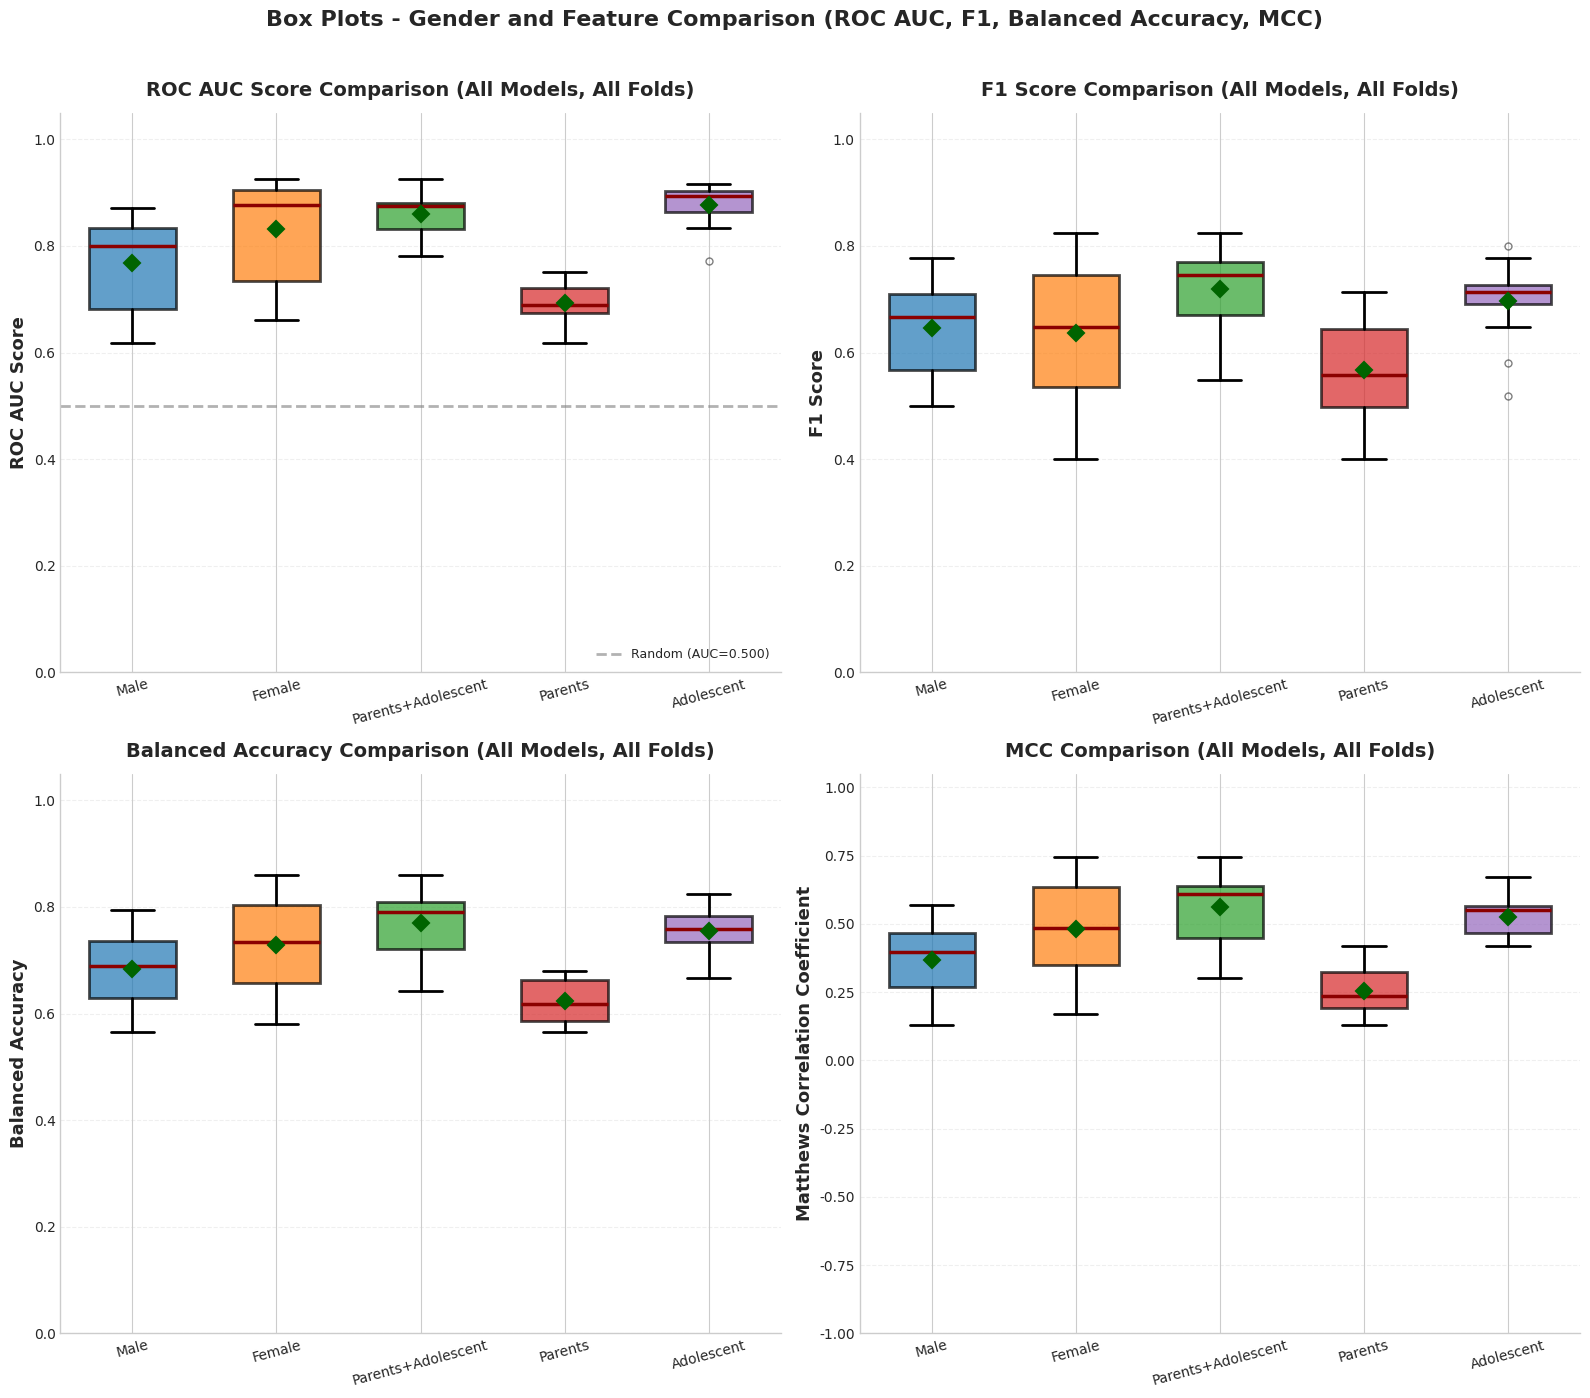


📊 Summary Statistics - ROC AUC
Male: Mean=0.7687, Median=0.7990, Std=0.0843, N=15
Female: Mean=0.8317, Median=0.8762, Std=0.0925, N=15
Parents+Adolescent: Mean=0.8601, Median=0.8746, Std=0.0385, N=15
Parents: Mean=0.6929, Median=0.6897, Std=0.0360, N=15
Adolescent: Mean=0.8761, Median=0.8944, Std=0.0376, N=15

📊 Summary Statistics - F1 Score
Male: Mean=0.6460, Median=0.6667, Std=0.0799, N=15
Female: Mean=0.6359, Median=0.6471, Std=0.1382, N=15
Parents+Adolescent: Mean=0.7184, Median=0.7451, Std=0.0833, N=15
Parents: Mean=0.5675, Median=0.5581, Std=0.0918, N=15
Adolescent: Mean=0.6970, Median=0.7129, Std=0.0681, N=15

📊 Summary Statistics - Balanced Accuracy
Male: Mean=0.6835, Median=0.6900, Std=0.0689, N=15
Female: Mean=0.7286, Median=0.7341, Std=0.0958, N=15
Parents+Adolescent: Mean=0.7708, Median=0.7905, Std=0.0641, N=15
Parents: Mean=0.6242, Median=0.6171, Std=0.0394, N=15
Adolescent: Mean=0.7544, Median=0.7583, Std=0.0396, N=15

📊 Summary Statistics - MCC
Male: Mean=0.3682, Median

In [42]:
# Box Plot 비교 - Gender and Feature Sets (Publication Quality)
# ROC AUC, F1 Score, Balanced Accuracy, MCC 비교
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

# Import MCC
from sklearn.metrics import matthews_corrcoef

# Font settings for publication
try:
    import matplotlib.font_manager as fm
    font_list = [f.name for f in fm.fontManager.ttflist]
    korean_fonts = ['NanumGothic', 'NanumBarunGothic', 'Malgun Gothic', 'AppleGothic', 'Noto Sans CJK KR']
    for font in korean_fonts:
        if font in font_list:
            matplotlib.rcParams['font.family'] = font
            break
except:
    pass

# Collect metrics by gender and feature sets
gender_metrics = {
    'Male': {'roc_auc': [], 'f1': [], 'balanced_acc': [], 'mcc': []},
    'Female': {'roc_auc': [], 'f1': [], 'balanced_acc': [], 'mcc': []}
}

feature_metrics = {
    'Parents+Adolescent': {'roc_auc': [], 'f1': [], 'balanced_acc': [], 'mcc': []},
    'Parents': {'roc_auc': [], 'f1': [], 'balanced_acc': [], 'mcc': []},
    'Adolescent': {'roc_auc': [], 'f1': [], 'balanced_acc': [], 'mcc': []}
}

def calculate_specificity(y_true, y_pred):
    """Calculate Specificity (True Negative Rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def calculate_balanced_accuracy(y_true, y_pred):
    """Calculate Balanced Accuracy"""
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = calculate_specificity(y_true, y_pred)
    return (recall + specificity) / 2

# Process each experiment
for exp_name, result in results_dict.items():
    exp_name_clean = result.get('exp_name', exp_name)
    feature_set = result.get('feature_set', '')
    gender = result.get('gender', '')
    test_labels = result.get('test_labels')
    test_preds = result.get('test_preds', {})
    test_proba = result.get('test_proba', {})
    
    if test_labels is None:
        continue
    if not isinstance(test_preds, dict) or not isinstance(test_proba, dict):
        continue
    
    # Determine feature group
    feature_group = None
    if feature_set == 'A':
        feature_group = 'Parents+Adolescent'
    elif feature_set == 'P':
        feature_group = 'Parents'
    elif feature_set == 'Ad':
        feature_group = 'Adolescent'
    
    # Determine gender group
    gender_group = None
    if gender == 'M':
        gender_group = 'Male'
    elif gender == 'FM':
        gender_group = 'Female'
    
    # Process each model
    for model_name in test_preds.keys():
        if model_name not in test_proba:
            continue
        
        preds_list = test_preds[model_name]
        proba_list = test_proba[model_name]
        
        if not isinstance(preds_list, list) or len(preds_list) == 0:
            continue
        if not isinstance(proba_list, list) or len(proba_list) == 0:
            continue
        
        # Calculate metrics for each fold
        for fold_pred, fold_proba in zip(preds_list, proba_list):
            # ROC AUC
            roc_auc = roc_auc_score(test_labels, fold_proba)
            
            # F1 Score
            f1 = f1_score(test_labels, fold_pred, zero_division=0)
            
            # Balanced Accuracy
            bal_acc = calculate_balanced_accuracy(test_labels, fold_pred)
            
            # MCC (Matthews Correlation Coefficient)
            mcc = matthews_corrcoef(test_labels, fold_pred)
            
            # Add to gender-based metrics
            if gender_group:
                gender_metrics[gender_group]['roc_auc'].append(roc_auc)
                gender_metrics[gender_group]['f1'].append(f1)
                gender_metrics[gender_group]['balanced_acc'].append(bal_acc)
                gender_metrics[gender_group]['mcc'].append(mcc)
            
            # Add to feature-based metrics
            if feature_group:
                feature_metrics[feature_group]['roc_auc'].append(roc_auc)
                feature_metrics[feature_group]['f1'].append(f1)
                feature_metrics[feature_group]['balanced_acc'].append(bal_acc)
                feature_metrics[feature_group]['mcc'].append(mcc)

# Publication-quality style settings
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('default')

# Color palette for publication
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("="*100)
print("📊 Box Plots - Gender and Feature Comparison (ROC AUC, F1, Balanced Accuracy, MCC)")
print("="*100)

# Create 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.patch.set_facecolor('white')

# ========== Top Left: ROC AUC Score ==========
ax = axes[0, 0]
all_data_roc = []
all_labels_roc = []

# Add gender data
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['roc_auc']) > 0:
        all_data_roc.append(gender_metrics[gender]['roc_auc'])
        all_labels_roc.append(gender)

# Add feature data
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['roc_auc']) > 0:
        all_data_roc.append(feature_metrics[feature]['roc_auc'])
        all_labels_roc.append(feature)

if len(all_data_roc) > 0:
    bp = ax.boxplot(all_data_roc, labels=all_labels_roc, patch_artist=True,
                    widths=0.6, showmeans=True, meanline=False,
                    boxprops=dict(linewidth=2, alpha=0.8),
                    whiskerprops=dict(linewidth=2),
                    capprops=dict(linewidth=2),
                    medianprops=dict(linewidth=2.5, color='darkred'),
                    meanprops=dict(marker='D', markerfacecolor='darkgreen', 
                                 markeredgecolor='darkgreen', markersize=8, markeredgewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, alpha=0.5, markeredgewidth=1))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(all_data_roc)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=2, alpha=0.6, label='Random (AUC=0.500)')
    ax.set_ylabel('ROC AUC Score', fontsize=13, fontweight='bold')
    ax.set_title('ROC AUC Score Comparison (All Models, All Folds)', fontsize=14, fontweight='bold', pad=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right', fontsize=9, framealpha=0.95, fancybox=True, shadow=True)
    ax.set_ylim([0.0, 1.05])
    ax.tick_params(axis='x', rotation=15)

# ========== Top Right: F1 Score ==========
ax = axes[0, 1]
all_data_f1 = []
all_labels_f1 = []

# Add gender data
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['f1']) > 0:
        all_data_f1.append(gender_metrics[gender]['f1'])
        all_labels_f1.append(gender)

# Add feature data
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['f1']) > 0:
        all_data_f1.append(feature_metrics[feature]['f1'])
        all_labels_f1.append(feature)

if len(all_data_f1) > 0:
    bp = ax.boxplot(all_data_f1, labels=all_labels_f1, patch_artist=True,
                    widths=0.6, showmeans=True, meanline=False,
                    boxprops=dict(linewidth=2, alpha=0.8),
                    whiskerprops=dict(linewidth=2),
                    capprops=dict(linewidth=2),
                    medianprops=dict(linewidth=2.5, color='darkred'),
                    meanprops=dict(marker='D', markerfacecolor='darkgreen', 
                                 markeredgecolor='darkgreen', markersize=8, markeredgewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, alpha=0.5, markeredgewidth=1))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(all_data_f1)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
    ax.set_title('F1 Score Comparison (All Models, All Folds)', fontsize=14, fontweight='bold', pad=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0.0, 1.05])
    ax.tick_params(axis='x', rotation=15)

# ========== Bottom Left: Balanced Accuracy ==========
ax = axes[1, 0]
all_data_bal = []
all_labels_bal = []

# Add gender data
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['balanced_acc']) > 0:
        all_data_bal.append(gender_metrics[gender]['balanced_acc'])
        all_labels_bal.append(gender)

# Add feature data
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['balanced_acc']) > 0:
        all_data_bal.append(feature_metrics[feature]['balanced_acc'])
        all_labels_bal.append(feature)

if len(all_data_bal) > 0:
    bp = ax.boxplot(all_data_bal, labels=all_labels_bal, patch_artist=True,
                    widths=0.6, showmeans=True, meanline=False,
                    boxprops=dict(linewidth=2, alpha=0.8),
                    whiskerprops=dict(linewidth=2),
                    capprops=dict(linewidth=2),
                    medianprops=dict(linewidth=2.5, color='darkred'),
                    meanprops=dict(marker='D', markerfacecolor='darkgreen', 
                                 markeredgecolor='darkgreen', markersize=8, markeredgewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, alpha=0.5, markeredgewidth=1))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(all_data_bal)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Balanced Accuracy Comparison (All Models, All Folds)', fontsize=14, fontweight='bold', pad=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0.0, 1.05])
    ax.tick_params(axis='x', rotation=15)

# ========== Bottom Right: MCC ==========
ax = axes[1, 1]
all_data_mcc = []
all_labels_mcc = []

# Add gender data
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['mcc']) > 0:
        all_data_mcc.append(gender_metrics[gender]['mcc'])
        all_labels_mcc.append(gender)

# Add feature data
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['mcc']) > 0:
        all_data_mcc.append(feature_metrics[feature]['mcc'])
        all_labels_mcc.append(feature)

if len(all_data_mcc) > 0:
    bp = ax.boxplot(all_data_mcc, labels=all_labels_mcc, patch_artist=True,
                    widths=0.6, showmeans=True, meanline=False,
                    boxprops=dict(linewidth=2, alpha=0.8),
                    whiskerprops=dict(linewidth=2),
                    capprops=dict(linewidth=2),
                    medianprops=dict(linewidth=2.5, color='darkred'),
                    meanprops=dict(marker='D', markerfacecolor='darkgreen', 
                                 markeredgecolor='darkgreen', markersize=8, markeredgewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, alpha=0.5, markeredgewidth=1))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(all_data_mcc)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Matthews Correlation Coefficient', fontsize=13, fontweight='bold')
    ax.set_title('MCC Comparison (All Models, All Folds)', fontsize=14, fontweight='bold', pad=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([-1.0, 1.05])
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('Box Plots - Gender and Feature Comparison (ROC AUC, F1, Balanced Accuracy, MCC)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Print summary statistics
print("\n" + "="*100)
print("📊 Summary Statistics - ROC AUC")
print("="*100)
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['roc_auc']) > 0:
        data = gender_metrics[gender]['roc_auc']
        print(f"{gender}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['roc_auc']) > 0:
        data = feature_metrics[feature]['roc_auc']
        print(f"{feature}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")

print("\n" + "="*100)
print("📊 Summary Statistics - F1 Score")
print("="*100)
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['f1']) > 0:
        data = gender_metrics[gender]['f1']
        print(f"{gender}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['f1']) > 0:
        data = feature_metrics[feature]['f1']
        print(f"{feature}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")

print("\n" + "="*100)
print("📊 Summary Statistics - Balanced Accuracy")
print("="*100)
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['balanced_acc']) > 0:
        data = gender_metrics[gender]['balanced_acc']
        print(f"{gender}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['balanced_acc']) > 0:
        data = feature_metrics[feature]['balanced_acc']
        print(f"{feature}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")

print("\n" + "="*100)
print("📊 Summary Statistics - MCC")
print("="*100)
for gender in ['Male', 'Female']:
    if len(gender_metrics[gender]['mcc']) > 0:
        data = gender_metrics[gender]['mcc']
        print(f"{gender}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")
for feature in ['Parents+Adolescent', 'Parents', 'Adolescent']:
    if len(feature_metrics[feature]['mcc']) > 0:
        data = feature_metrics[feature]['mcc']
        print(f"{feature}: Mean={np.mean(data):.4f}, Median={np.median(data):.4f}, "
              f"Std={np.std(data):.4f}, N={len(data)}")

print("\n✅ Box plots generation completed (Publication quality)")

## 3. Confusion Matrix 비교


In [ ]:
# Visualize Confusion Matrix by experimental method for the LightGBM model
target_model = 'LightGBM'

def format_exp_name(exp_name):
    """Format experimental name to be human-readable in English"""
    if not exp_name or not isinstance(exp_name, str):
        return exp_name

    parts = exp_name.replace('4_EXP_Methods_', '').split('_')
    if len(parts) >= 2:
        feature_set = parts[0]
        gender = parts[1]

        feature_map = {'A': 'Parents+Adolescent', 'P': 'Parents', 'Ad': 'Adolescent'}
        gender_map = {'A': 'All', 'M': 'Male', 'FM': 'Female'}

        feature_label = feature_map.get(feature_set, feature_set)
        gender_label = gender_map.get(gender, gender)

        return f"{feature_label} ({gender_label})"
    return exp_name

# Collect all experimental combinations for LightGBM model
lightgbm_combinations = []
for exp_name, result in results_dict.items():
    exp_name_clean = result.get('exp_name', exp_name)
    test_labels = result.get('test_labels')
    test_preds = result.get('test_preds', {})

    if test_labels is None:
        continue
    if not isinstance(test_preds, dict):
        continue

    if target_model not in test_preds:
        continue

    preds_list = test_preds[target_model]
    if isinstance(preds_list, list) and len(preds_list) > 0:
        lightgbm_combinations.append((exp_name_clean, test_labels, preds_list))

if len(lightgbm_combinations) == 0:
    print(f"⚠️  No data available for {target_model} model.")
else:
    # Calculate AUC for each experimental method
    exp_combinations_with_auc = []

    for exp_name, test_labels, preds_list in lightgbm_combinations:
        # AUC requires test_proba
        for exp_key, result in results_dict.items():
            exp_name_clean = result.get('exp_name', exp_key)
            if exp_name_clean == exp_name:
                test_proba = result.get('test_proba', {})
                if target_model in test_proba:
                    proba_list = test_proba[target_model]
                    if isinstance(proba_list, list) and len(proba_list) > 0:
                        proba_array = np.array(proba_list)
                        avg_proba = np.mean(proba_array, axis=0)
                        auc = roc_auc_score(test_labels, avg_proba)
                        exp_combinations_with_auc.append((exp_name, auc, test_labels, preds_list))
                        break

    # Sort by AUC in descending order
    exp_combinations_with_auc.sort(key=lambda x: x[1], reverse=True)

    # Arrange in 3x3 layout based on feature set and gender order
    # Order: A_A, A_M, A_FM, P_A, P_M, P_FM, Ad_A, Ad_M, Ad_FM
    exp_order = [
        '4_EXP_Methods_A_A', '4_EXP_Methods_A_M', '4_EXP_Methods_A_FM',
        '4_EXP_Methods_P_A', '4_EXP_Methods_P_M', '4_EXP_Methods_P_FM',
        '4_EXP_Methods_Ad_A', '4_EXP_Methods_Ad_M', '4_EXP_Methods_Ad_FM'
    ]

    # Rearrange based on order
    layout_combinations = []
    layout_auc_values = []

    for exp_name in exp_order:
        for exp_key, auc, test_labels, preds_list in exp_combinations_with_auc:
            if exp_key == exp_name:
                layout_combinations.append((exp_key, test_labels, preds_list))
                layout_auc_values.append(auc)
                break

    # If any experimental results are not in the specified order, add them to the end
    for exp_key, auc, test_labels, preds_list in exp_combinations_with_auc:
        if exp_key not in [x[0] for x in layout_combinations]:
            layout_combinations.append((exp_key, test_labels, preds_list))
            layout_auc_values.append(auc)

    cols = 3
    rows = 3

    # Create 3x3 layout
    fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
    axes = axes.flatten()

    # Find max value from all confusion matrices for shared colorbar
    all_cm_values = []
    for exp_name, test_labels, preds_list in layout_combinations:
        preds_array = np.array(preds_list)
        hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode
        cm = confusion_matrix(test_labels, hard_voting_pred)
        all_cm_values.append(cm)

    vmin = 0
    vmax = max([cm.max() for cm in all_cm_values])

    # Plot confusion matrix for each experimental method (with colorbar turned off)
    for idx, (exp_name, test_labels, preds_list) in enumerate(layout_combinations):
        formatted_label = format_exp_name(exp_name)

        # Hard Voting (majority vote)
        preds_array = np.array(preds_list)  # (n_folds, n_samples)
        hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode

        # Calculate confusion matrix (count)
        cm = confusion_matrix(test_labels, hard_voting_pred)

        # Metrics calculation
        accuracy = accuracy_score(test_labels, hard_voting_pred)
        precision = precision_score(test_labels, hard_voting_pred, zero_division=0)
        recall = recall_score(test_labels, hard_voting_pred, zero_division=0)
        f1 = f1_score(test_labels, hard_voting_pred, zero_division=0)

        # Visualization
        ax = axes[idx]

        # Confusion matrix heatmap (count, without colorbar)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    cbar=False, linewidths=2, linecolor='black', vmin=vmin, vmax=vmax,
                    annot_kws={'size': 11, 'weight': 'bold'})

        # Set title (include AUC)
        auc_val = layout_auc_values[idx] if idx < len(layout_auc_values) else 0.0
        ax.set_title(f'{formatted_label}\nAcc: {accuracy:.3f} | F1: {f1:.3f} | AUC: {auc_val:.3f}',
                     fontsize=10, fontweight='bold', pad=8)
        ax.set_xlabel('Predicted', fontsize=9, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=9, fontweight='bold')
        ax.set_xticklabels(['Class 0', 'Class 1'], fontsize=9)
        ax.set_yticklabels(['Class 0', 'Class 1'], fontsize=9, rotation=0)

    # Remove unused subplots
    for idx in range(len(layout_combinations), len(axes)):
        fig.delaxes(axes[idx])

    # Add shared colorbar on the right (covering all 3 rows)
    # Reserve space for colorbar before calling tight_layout
    plt.tight_layout(rect=[0, 0, 0.92, 1.0])  # [left, bottom, right, top]

    # Create axes for colorbar (match the entire height of the 3 rows)
    cbar_ax = fig.add_axes([0.93, 0.1, 0.015, 0.8])  # [left, bottom, width, height]

    # Create shared colorbar (using dummy data)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Count', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)

    plt.suptitle(f'{target_model} - Confusion Matrix by Experimental Methods (Count)',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

    # Print metrics table
    print("=" * 80)
    print(f"{target_model} model - Confusion Matrix Analysis by Experimental Method")
    print("=" * 80)
    print(f"{'Rank':<5} {'Experiment Method':<40} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
    
    print("-" * 80)

    for rank, (exp_name, test_labels, preds_list) in enumerate(layout_combinations, 1):
        formatted_label = format_exp_name(exp_name)

        # Hard Voting
        preds_array = np.array(preds_list)
        hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode

        # Metric calculation
        accuracy = accuracy_score(test_labels, hard_voting_pred)
        precision = precision_score(test_labels, hard_voting_pred, zero_division=0)
        recall = recall_score(test_labels, hard_voting_pred, zero_division=0)
        f1 = f1_score(test_labels, hard_voting_pred, zero_division=0)
        auc_val = layout_auc_values[rank - 1] if rank <= len(layout_auc_values) else 0.0

        print(f"{rank:<5} {formatted_label:<40} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {auc_val:<10.4f}")

    print(f"\n✅ Displayed Confusion Matrices for {len(layout_combinations)} experimental methods successfully.")
